# (guebin) Eearthquake
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

### imports

In [21]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

### load data and clean it

`-` load

In [22]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


`-` cleaning

In [23]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

3378    1975-02-23T02:58:41.000Z
Name: Date, dtype: object

In [24]:
df.iloc[3378,0] = '02/03/1975'

In [25]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

7512    1985-04-28T02:53:41.530Z
Name: Date, dtype: object

In [26]:
df.iloc[7512,0] = '04/28/1985'

In [27]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object

In [28]:
df.iloc[20650,0] = '03/13/2011'

In [29]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

,Latitude,Longitude,Magnitude,Year
0,19.2460,145.6160,6.0,1965
1,1.8630,127.3520,5.8,1965
2,-20.5790,-173.9720,6.2,1965
3,-59.0760,-23.5570,5.8,1965
4,11.9380,126.4270,5.8,1965
...,...,...,...,...
23407,38.3917,-118.8941,5.6,2016
23408,38.3777,-118.8957,5.5,2016
23409,36.9179,140.4262,5.9,2016
23410,-9.0283,118.6639,6.3,2016


In [30]:
df.Year = df.Year.astype(np.float64)

### define class

In [48]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
#         nlst = self.df.groupby('Year').aggregate(len).Latitude.tolist()
#         nlst = [0]+np.cumsum(nlst).tolist()
#         beta_matrix = np.zeros([self.n,self.n])
#         for i in range(len(nlst)-1):
#             beta_matrix[nlst[i]:nlst[i+1],nlst[i]:nlst[i+1]] = beta
#         self.W = self.W * beta_matrix 
#     def _get_laplacian(self):
#         self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
#         self.lamb, self.Psi = np.linalg.eigh(self.L)
#         self.Lamb = np.diag(self.lamb)  

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 1
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

### analysis

`-` make instance for analysis

In [59]:
moo=MooYaHo(df.query("Year == 2016"))

- 테스트용으로 2016년 자료만 수집

`-` get distance 

In [60]:
moo.get_distance()

100%|██████████| 469/469 [00:00<00:00, 2060.34it/s]


In [61]:
moo.D[moo.D>0].mean()

8647.918085847994

- 0이 아닌 거리의 평균은 8600정도?

(array([18438., 25088., 29216., 29204., 30978., 28712., 22932., 17002.,
        13158.,  4764.]),
 array([3.09519959e-01, 1.99516074e+03, 3.99001197e+03, 5.98486319e+03,
        7.97971442e+03, 9.97456564e+03, 1.19694169e+04, 1.39642681e+04,
        1.59591193e+04, 1.79539705e+04, 1.99488218e+04]),
 <BarContainer object of 10 artists>)

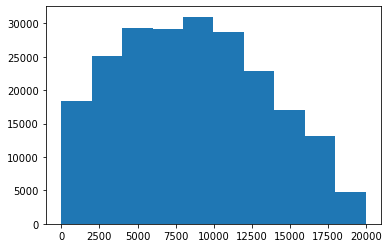

In [62]:
plt.hist(moo.D[moo.D>0])

- 히스토그램결과 -> 2500보다 거리가 작으면 거의 같은 지역이라고 봐도 무방할듯

`-` weight matrix

In [63]:
moo.get_weightmatrix(theta=(8647.92),kappa=2500) 

- 평균적으로 노드는 `np.exp(-(dist/8647)**2)=np.exp(-1)=0.36787944117144233` 정도의 연결강도를 가진다. 
- 거리가 2500이하이면 weight를 1로 설정한다. 

`-` fit

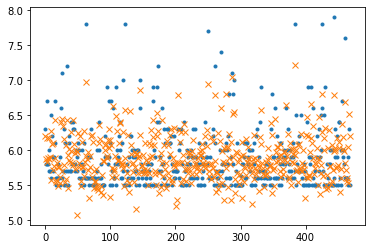

In [64]:
moo.fit(m=250)

`-` vis

In [68]:
# 
#moo.vis(MagThresh=7,ResThresh=1) # <- 실행해봐요

- 전체자료는 underlying에 위치 
- 지진강도가 MagThresh 이상인 자료는 붉은점으로 시각화함 
- 이상치정도(우리가 제안하는 새로운 메져) ResThresh 이상인 자료는 파란점으로 시각화함 

### 한계점 (?)

`-` 시간효과를 따로 모형화하지는 않음 